# platypusを使った多目的最適化
- 参考サイト：https://watlab-blog.com/2021/12/26/platypus-opt-nsga2/

In [6]:
import pandas as pd

from platypus import NSGAII, Problem, Real, Integer, nondominated
from matplotlib import pyplot as plt

# 2群選定

In [16]:
# サンプルデータ読み込み
df = pd.read_excel("../data/todofuken.xlsx", index_col="ymd")
df.head(3)

北海道        青森県        岩手県        宮城県        秋田県        山形県  \
ymd                                                                            
2020-04-01  10.938722  28.648354   0.782961  18.345855  26.528310  85.000745   
2020-04-02   5.388023  47.907413  98.985539  28.629193  69.693684  14.694652   
2020-04-03  59.245862  36.847111   5.524244  12.823431  78.187246  93.400769   

                  福島県        茨城県        栃木県        群馬県  ...        愛媛県  \
ymd                                                     ...              
2020-04-01  36.063244  81.395722   3.739695  90.897199  ...  13.963986   
2020-04-02  24.311023   6.096715  22.752639  39.004277  ...  89.721631   
2020-04-03  63.953242  30.906090  85.804783  75.532037  ...  36.200313   

                  高知県        福岡県        佐賀県        長崎県        熊本県        大分県  \
ymd                                                                            
2020-04-01   0.297759  11.872975  40.307507  30.924841  23.612126  20.199211   
2020-04-02  92.644821  59.654697  96.221145   7.594614  50.572441  35.016871   
2020-04-03   8.727330  54.821192  86.393889   5.597330  75.383654  41.823502   

                  宮崎県       鹿児島県        沖縄県  
ymd                                          
2020-04-01  34.635291  38.887168  72.117658  
2020-04-02  27.353816  25.595032  12.428990  
2020-04-03  90.461639  33.333180  80.030058  

[3 rows x 47 columns]

In [27]:
# エリアを定義
Kanto = ["茨城県", "栃木県", "群馬県", "埼玉県", "千葉県", "東京都", "神奈川県"]
Kansai = ["滋賀県", "京都府", "大阪府", "兵庫県", "奈良県", "和歌山県"]
Tokai = ["岐阜県", "愛知県", "三重県"]

kensyo_area = Kanto + Kansai + Tokai
jogai_area = []

df = df[kensyo_area]

# エリア毎の対象都道府県もdfカラム番号を各リストにまとめる
kanto_list = [i for i,x in enumerate(list(df.columns)) if x in Kanto]
kansai_list = [i for i,x in enumerate(list(df.columns)) if x in Kansai]
tokai_list = [i for i,x in enumerate(list(df.columns)) if x in Tokai]

In [36]:
# 損失関数を定義
class select_2group:
    # 関数1：1階差分の相関係数
    def loss_func_1(self, v1,v2):
        df = pd.DataFrame(
            {
                'v1':v1,
                'v2':v2
            })
        # 1階差分の相関係数を計算
        corr = 1 - df.diff().corr().iloc[0,1]

        return corr

    # 関数2：２群間の実数値差分の期間平均値
    def loss_func_2(self, v1,v2):
        df = pd.DataFrame(
            {
                'v1':v1,
                'v2':v2
            })
        # ２群間の実数値差分の期間平均値
        df['v3'] = df['v1'] - df['v2']
        abs_diff = abs(df['v3']).mean(axis=0)

        return abs_diff

    # 目的関数
    def objective(self, vars):
        flag0_list = []
        flag1_list = []

        for i, flag in enumerate(vars):
            if flag == 0:
                flag0_list.append(i)
            else:
                flag1_list.append(i)

        # flag1から関東を削除
        if set(flag0_list) & set(kanto_list): # flag0_listに関東が入っていたらTrueを返す
            flag1_list = list(set(flag1_list) - set(kanto_list))
        # flag1から関西を削除
        if set(flag0_list) & set(kansai_list): # flag0_listに関西が入っていたらTrueを返す
            flag1_list = list(set(flag1_list) - set(kansai_list))
        # flag1から東海を削除
        if set(flag0_list) & set(tokai_list): # flag0_listに東海が入っていたらTrueを返す
            flag1_list = list(set(flag1_list) - set(tokai_list))

        # プロモ除外エリアがあれば除外する
        jogai_area = self.jogai_area
        flag0_list = list(set(flag0_list) - set(jogai_area))
        flag1_list = list(set(flag1_list) - set(jogai_area))

        # 空のdataframeを作成
        df_master = pd.DataFrame(
                        data = {'v1':[0]*len(df)},
                        index= df.index
                    )
        df_flag0 = df_master.copy()
        df_flag1 = df_master.copy()

        # flag毎に合計する
        for i in flag0_list:
            df_flag0['v1'] += df.iloc[:,i]
        for i in flag1_list:   
            df_flag1['v1'] += df.iloc[:,i]

        # 損失関数に渡すようにリスト化する
        A0 = df_flag0['v1'].tolist()
        A1 = df_flag1['v1'].tolist()
        
        f1 = self.loss_func_1(A0, A1)
        f2 = self.loss_func_1(A1, A1)

        return [f1, f2]

    # 最適化計算を実行する関数
    def optimization(self, n_var, n_obj, vars, n_run, jogai_area):
            self.jogai_area = jogai_area
            for i, area in enumerate(jogai_area):
                self.jogai_area[i] = df.columns.get_loc(area)

            # 設計変数と目的関数の数を設定
            problem = Problem(n_var, n_obj)

            # 最適化問題に最小化を設定
            problem.directions[:] = Problem.MINIMIZE
            
            # 設計変数と目的関数を設定
            problem.types[:] = vars
            problem.function = self.objective

            # 最適化アルゴリズムを設定して計算を実行する
            algorithm = NSGAII(problem)
            algorithm.run(n_run)
            
            return algorithm

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

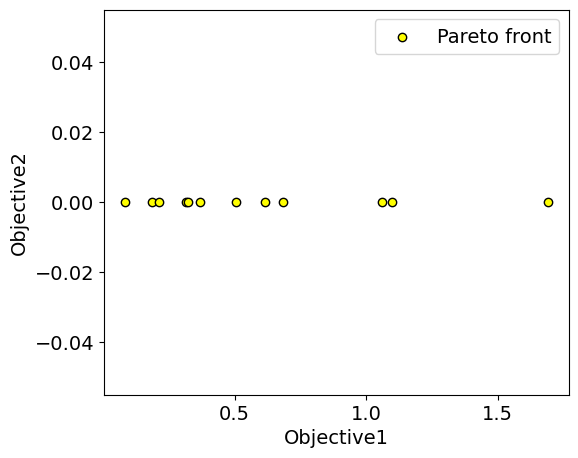

In [37]:
# 変数を設定する
vars = []
for i in range(df.shape[1]):
    var = Integer(0., 1.)
    vars.append(var)
# classを読み込み
myfunc = select_2group()

# 最適化計算を実行する
algorithm = myfunc.optimization(n_var=len(vars), n_obj=2, vars=vars, n_run=100, jogai_area=jogai_area)

# ここからグラフ描画
# フォント種類とサイズを設定する
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# グラフの入れ物を用意する
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)

# 軸のラベルを設定する
ax1.set_xlabel('Objective1')
ax1.set_ylabel('Objective2')

# 最適化結果から実現可能解をプロットする
obj1 = []
obj2 = []

for solution in algorithm.result:
    obj1.append(solution.objectives[0])
    obj2.append(solution.objectives[1])
ax1.scatter(obj1, obj2, color='yellow', edgecolor='black', label='Pareto front')
ax1.legend()

# グラフを表示する
plt.show()
plt.close()

In [38]:
# パレート解をプロットする
n_dominated = nondominated(algorithm.result)
obj1 = []
obj2 = []
for i, solution in enumerate(n_dominated):
    obj1.append(solution.objectives[0])
    obj2.append(solution.objectives[1])
    print(f'Var={i}', 'Obj=', solution.objectives[0], solution.objectives[1])

Var=0 Obj= nan nan
Var=1 Obj= nan nan
Var=2 Obj= nan nan
Var=3 Obj= nan nan
Var=4 Obj= nan nan
Var=5 Obj= nan nan
Var=6 Obj= nan nan
Var=7 Obj= nan nan
Var=8 Obj= nan nan
Var=9 Obj= nan nan
Var=10 Obj= nan nan
Var=11 Obj= nan nan
Var=12 Obj= nan nan
Var=13 Obj= nan nan
Var=14 Obj= nan nan
Var=15 Obj= nan nan
Var=16 Obj= nan nan
Var=17 Obj= nan nan
Var=18 Obj= nan nan
Var=19 Obj= nan nan
Var=20 Obj= nan nan
Var=21 Obj= nan nan
Var=22 Obj= nan nan
Var=23 Obj= nan nan
Var=24 Obj= nan nan
Var=25 Obj= nan nan
Var=26 Obj= nan nan
Var=27 Obj= 0.0839661161429861 0.0
Var=28 Obj= nan nan
Var=29 Obj= nan nan
Var=30 Obj= nan nan
Var=31 Obj= nan nan
Var=32 Obj= nan nan
Var=33 Obj= nan nan
Var=34 Obj= nan nan
Var=35 Obj= nan nan
Var=36 Obj= nan nan
Var=37 Obj= nan nan
Var=38 Obj= nan nan
Var=39 Obj= nan nan
Var=40 Obj= nan nan
Var=41 Obj= nan nan
Var=42 Obj= nan nan
Var=43 Obj= nan nan
Var=44 Obj= nan nan
Var=45 Obj= nan nan
Var=46 Obj= nan nan
Var=47 Obj= nan nan
Var=48 Obj= nan nan
Var=49 Obj= nan